# Reading the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('../input/creditcard-fraud-detection/creditcard.csv')

# Correlation matrix

In [3]:
df.corr() \
    .style.background_gradient(cmap='coolwarm') \
    .format(precision = 2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.00,0.12,-0.01,-0.42,-0.11,0.17,-0.06,0.08,-0.04,-0.01,0.03,-0.25,0.12,-0.07,-0.10,-0.18,0.01,-0.07,0.09,0.03,-0.05,0.04,0.14,0.05,-0.02,-0.23,-0.04,-0.01,-0.01,-0.01,-0.01
V1,0.12,1.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.23,-0.10
V2,-0.01,0.00,1.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.53,0.09
V3,-0.42,-0.00,0.00,1.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.21,-0.19
V4,-0.11,-0.00,-0.00,0.00,1.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.10,0.13
V5,0.17,0.00,0.00,-0.00,-0.00,1.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.39,-0.09
V6,-0.06,-0.00,0.00,0.00,-0.00,0.00,1.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.22,-0.04
V7,0.08,-0.00,0.00,0.00,-0.00,0.00,0.00,1.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.40,-0.19
V8,-0.04,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,1.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.10,0.02
V9,-0.01,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.04,-0.10


# Machine learning

## Common operations

### Importing require modules#### 

In [4]:
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

### Preparing the comparison table

In [5]:
columns = ['Model','accuracy score', ' Precision','Recall','f1_score']
evaluation_df = pd.DataFrame(columns=columns)

### Drawing ROC

In [6]:
def drawROC(model, X_test, y_test):
    pred = model.predict(X_test)
    metrics.RocCurveDisplay.from_predictions(y_test, pred)
    plt.show()

### Executing a given algorithm

In [7]:
def execute_ml(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    
    accuracy_score  = metrics.accuracy_score(y_test,pred)
    precision_score = metrics.precision_score(y_test, pred)
    recall_score = metrics.recall_score(y_test, pred)
    f1_score = metrics.f1_score(y_test,pred)
    evaluation_df.loc[len(evaluation_df.index)] = [type(model).__name__,accuracy_score,precision_score,recall_score, f1_score]    
    
    print(metrics.classification_report(y_test,pred))
        
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred)
    plt.show()
    
    return model

### Cross validation

In [8]:
def perform_cross_validation(model, X_train, y_train):
    cross_validation_result = cross_validate(model,
                                             X_train, y_train,
                                             return_train_score=True)

    return cross_validation_result

### Tweaking threshold

Instead of using the predefined <i>predict</i>, the function is customized to use the given threshold.

In [9]:
def execute_using_threshold(model, X_train, y_train, t):
    model.fit(X_train,y_train)
    pred_prob = model.predict_proba(X_test)
    pred = [1 if pred_prob[i][1]> t else 0 for i in range(len(pred_prob))]
    
    print("Threshold: %f" %t)
    print(metrics.classification_report(y_test,pred))
    metrics.ConfusionMatrixDisplay.from_predictions(y_test,pred)
    plt.show()

## Specifying the independent and target features

In [10]:
X=df.drop("Class",axis='columns')
y=df["Class"]

## Splitting the dataset into training and testing subsets
<br>
<b>random_state</b> simply initializes the randomizer and can be any number
<br>
<b>test_size</b> and <b>train_size</b> are fractions of the whole dataset

In [11]:
np.random.seed(42)

X_train ,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=12,test_size = 0.025, train_size=0.1)

## Machine learning algorithms

### K-Nearest Neighbors

C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       0.00      0.00      0.00        12

    accuracy                           1.00      7121
   macro avg       0.50      0.50      0.50      7121
weighted avg       1.00      1.00      1.00      7121



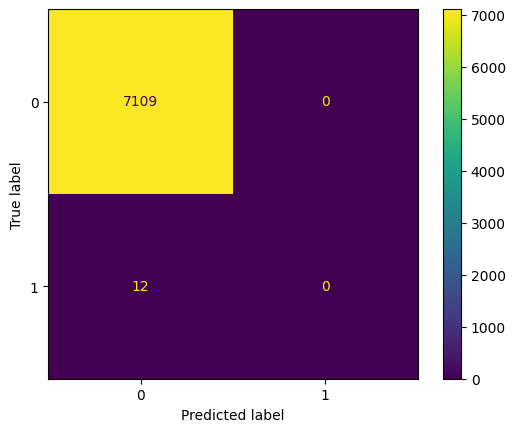

KNeighborsClassifier(n_neighbors=15, weights='distance')

In [12]:
execute_ml(KNeighborsClassifier(n_neighbors = 15, weights='distance'),
           X_train, y_train, X_test, y_test)

### Logistic regression

C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       0.75      0.50      0.60        12

    accuracy                           1.00      7121
   macro avg       0.87      0.75      0.80      7121
weighted avg       1.00      1.00      1.00      7121



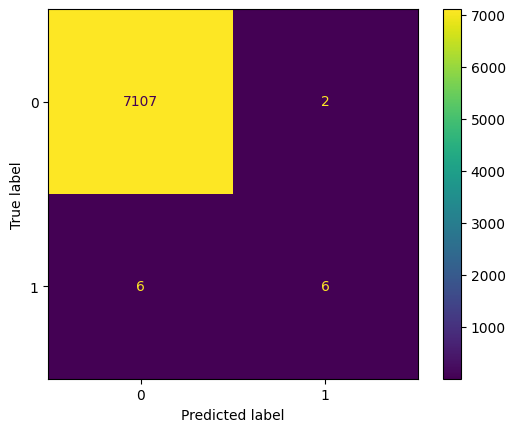

LogisticRegression(max_iter=200, random_state=12)

In [13]:
execute_ml(LogisticRegression(max_iter=200,random_state=12),
           X_train, y_train, X_test, y_test)

### Logistic regression CV

C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       0.75      0.50      0.60        12

    accuracy                           1.00      7121
   macro avg       0.87      0.75      0.80      7121
weighted avg       1.00      1.00      1.00      7121



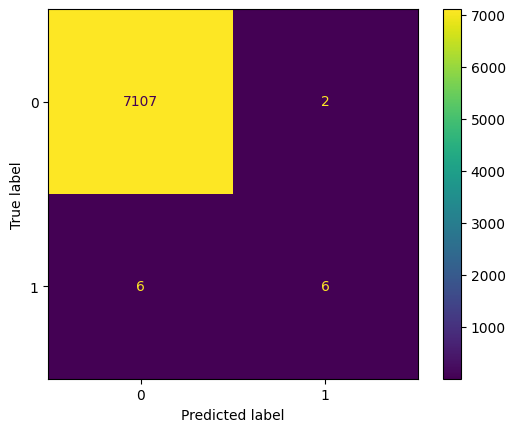

LogisticRegressionCV(cv=KFold(n_splits=10, random_state=12, shuffle=True),
                     max_iter=200, random_state=12, scoring='roc_auc', tol=10)

In [14]:
execute_ml(LogisticRegressionCV(max_iter=200,penalty='l2',
                                scoring='roc_auc',
                                cv=KFold(n_splits=10, shuffle=True, random_state=12),
                                tol=10,random_state=12),
           X_train, y_train, X_test, y_test)

### Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       0.80      0.67      0.73        12

    accuracy                           1.00      7121
   macro avg       0.90      0.83      0.86      7121
weighted avg       1.00      1.00      1.00      7121



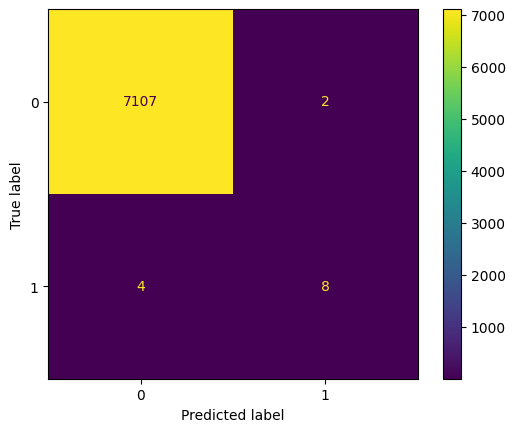

BernoulliNB(alpha=1)

In [15]:
execute_ml(BernoulliNB(alpha=1),
           X_train, y_train, X_test, y_test)

### Random forest

#### Random forest + gini

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       1.00      0.58      0.74        12

    accuracy                           1.00      7121
   macro avg       1.00      0.79      0.87      7121
weighted avg       1.00      1.00      1.00      7121



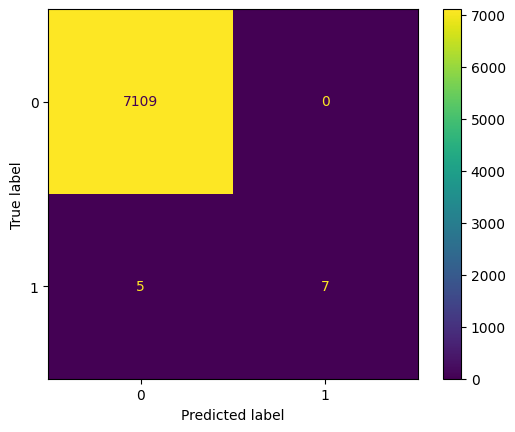

RandomForestClassifier(random_state=12)

In [16]:
execute_ml(RandomForestClassifier(bootstrap = True,
                                  max_features = 'sqrt',
                                  random_state=12),
           X_train, y_train, X_test, y_test)

#### Random forest + entropy

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       1.00      0.58      0.74        12

    accuracy                           1.00      7121
   macro avg       1.00      0.79      0.87      7121
weighted avg       1.00      1.00      1.00      7121



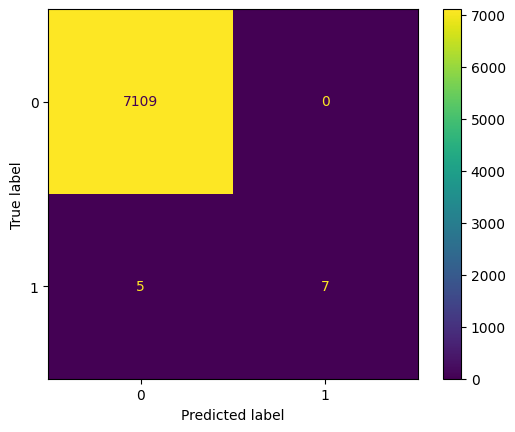

RandomForestClassifier(criterion='entropy', random_state=12)

In [17]:
execute_ml(RandomForestClassifier(bootstrap = True,
                                  criterion='entropy',
                                  max_features = 'sqrt',
                                  random_state=12),
           X_train, y_train, X_test, y_test)

### Gradient Boosting classifier

C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       0.00      0.00      0.00        12

    accuracy                           1.00      7121
   macro avg       0.50      0.50      0.50      7121
weighted avg       1.00      1.00      1.00      7121



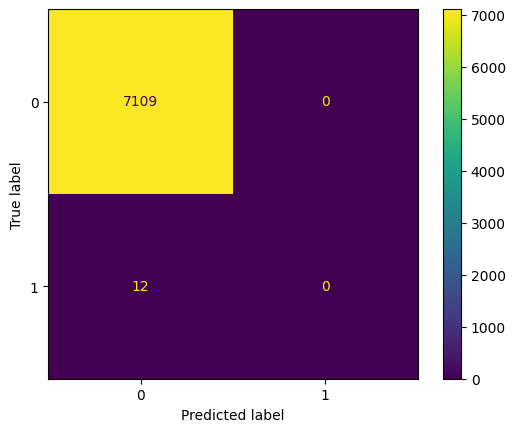

GradientBoostingClassifier()

In [18]:
execute_ml(GradientBoostingClassifier(),
           X_train, y_train, X_test, y_test)

### AdaBoost classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       1.00      0.67      0.80        12

    accuracy                           1.00      7121
   macro avg       1.00      0.83      0.90      7121
weighted avg       1.00      1.00      1.00      7121



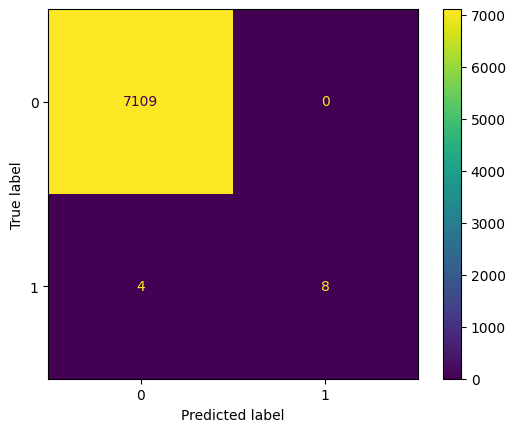

AdaBoostClassifier(n_estimators=200, random_state=12)

In [19]:
execute_ml(AdaBoostClassifier(n_estimators=200, random_state=12),
           X_train, y_train, X_test, y_test)

### XGBoost classifier

[19:50:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       1.00      0.67      0.80        12

    accuracy                           1.00      7121
   macro avg       1.00      0.83      0.90      7121
weighted avg       1.00      1.00      1.00      7121



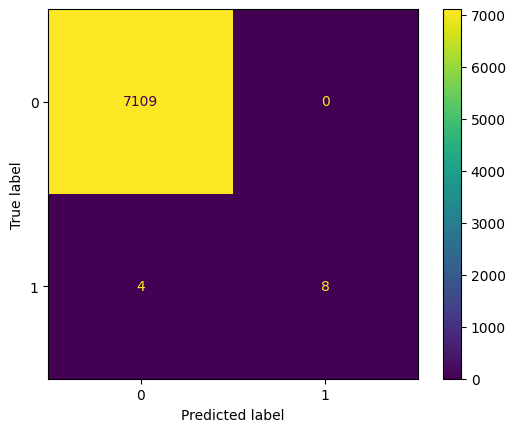

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              cv=KFold(n_splits=10, random_state=12, shuffle=True),
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [20]:
execute_ml(XGBClassifier(cv=KFold(n_splits=10, random_state=12, shuffle=True),
                         learning_rate=0.01),
           X_train, y_train, X_test, y_test)

### SVM

C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       0.00      0.00      0.00        12

    accuracy                           1.00      7121
   macro avg       0.50      0.50      0.50      7121
weighted avg       1.00      1.00      1.00      7121



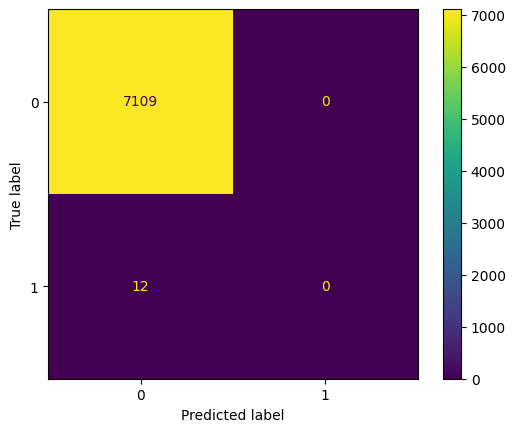

SVC(random_state=12)

In [21]:
execute_ml(svm.SVC(probability=False, random_state=12),
           X_train, y_train, X_test, y_test)

### Bagging classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       1.00      0.67      0.80        12

    accuracy                           1.00      7121
   macro avg       1.00      0.83      0.90      7121
weighted avg       1.00      1.00      1.00      7121



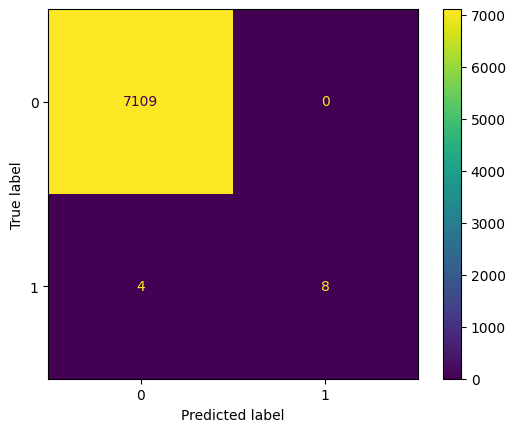

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=0.8,
                  max_samples=0.8, n_estimators=200, oob_score=True,
                  random_state=12)

In [22]:
execute_ml(BaggingClassifier(DecisionTreeClassifier(),
                             n_estimators=200,
                             max_samples=0.8,
                             max_features=0.8,
                             oob_score=True,
                             random_state=12),
           X_train, y_train, X_test, y_test)

## Evaluation

In [23]:
evaluation_df

,Model,accuracy score,Precision,Recall,f1_score
0,KNeighborsClassifier,0.998315,0.00,0.000000,0.000000
1,LogisticRegression,0.998877,0.75,0.500000,0.600000
2,LogisticRegressionCV,0.998877,0.75,0.500000,0.600000
3,BernoulliNB,0.999157,0.80,0.666667,0.727273
4,RandomForestClassifier,0.999298,1.00,0.583333,0.736842
5,RandomForestClassifier,0.999298,1.00,0.583333,0.736842
6,GradientBoostingClassifier,0.998315,0.00,0.000000,0.000000
7,AdaBoostClassifier,0.999438,1.00,0.666667,0.800000
8,XGBClassifier,0.999438,1.00,0.666667,0.800000
9,SVC,0.998315,0.00,0.000000,0.000000


## Overfit analysis using cross validation

Cross validating the training VS testing performance using the selected model. If the measurements are not that far apart means that there is not a considerable overfit.

In [24]:
perform_cross_validation(
    RandomForestClassifier(bootstrap = True,
                           criterion='entropy',
                           verbose=1,
                           oob_score=True,
                           max_features = 'sqrt',
                           random_state=12),
    X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

{'fit_time': array([ 9.07276058,  7.41791368,  8.15381193,  8.16750717, 10.30854511]),
 'score_time': array([0.06292653, 0.04688334, 0.04687786, 0.09421015, 0.0845778 ]),
 'test_score': array([0.99877107, 0.99929775, 0.99929775, 0.99929775, 0.99929775]),
 'train_score': array([1., 1., 1., 1., 1.])}

## Threshold tweaking

Checking the performance agaist different thresholds (extracted from the ROC curve) in order to find and optimum with regards to the case study (Whether it is more important to classify Positives or Negatives)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       1.00      0.58      0.74        12

    accuracy                           1.00      7121
   macro avg       1.00      0.79      0.87      7121
weighted avg       1.00      1.00      1.00      7121



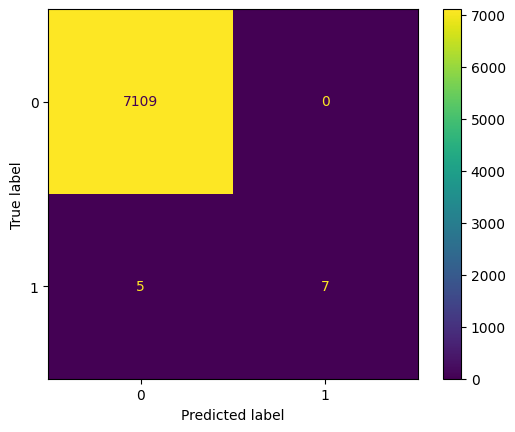

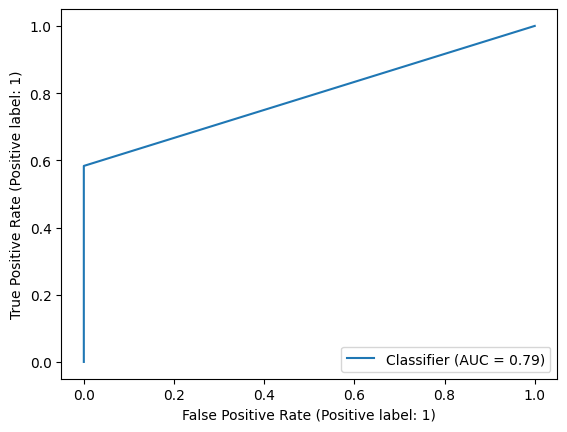

Threshold: 0.100000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       0.75      0.75      0.75        12

    accuracy                           1.00      7121
   macro avg       0.87      0.87      0.87      7121
weighted avg       1.00      1.00      1.00      7121



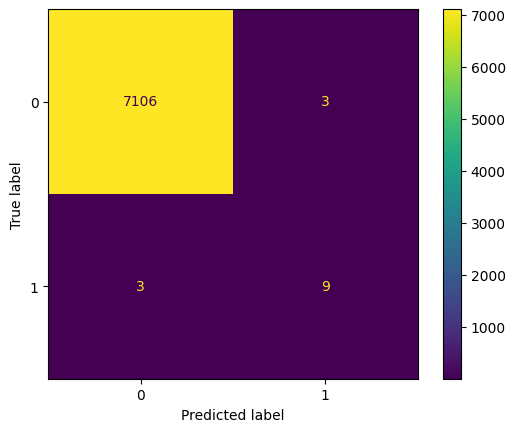

Threshold: 0.300000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       1.00      0.67      0.80        12

    accuracy                           1.00      7121
   macro avg       1.00      0.83      0.90      7121
weighted avg       1.00      1.00      1.00      7121



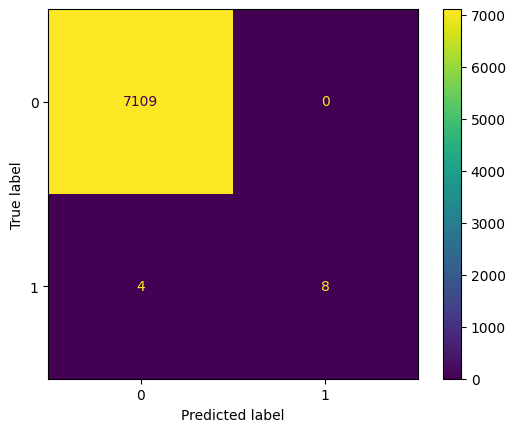

Threshold: 0.500000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       1.00      0.58      0.74        12

    accuracy                           1.00      7121
   macro avg       1.00      0.79      0.87      7121
weighted avg       1.00      1.00      1.00      7121



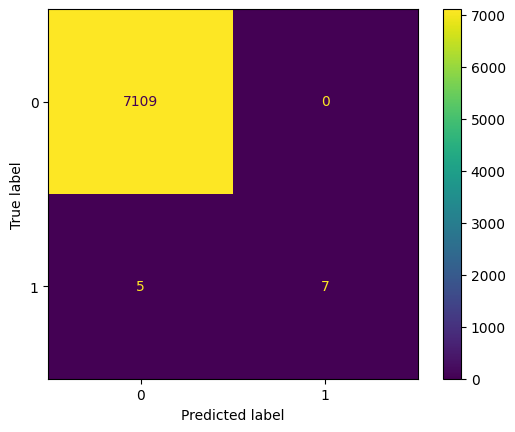

Threshold: 0.700000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       1.00      0.58      0.74        12

    accuracy                           1.00      7121
   macro avg       1.00      0.79      0.87      7121
weighted avg       1.00      1.00      1.00      7121



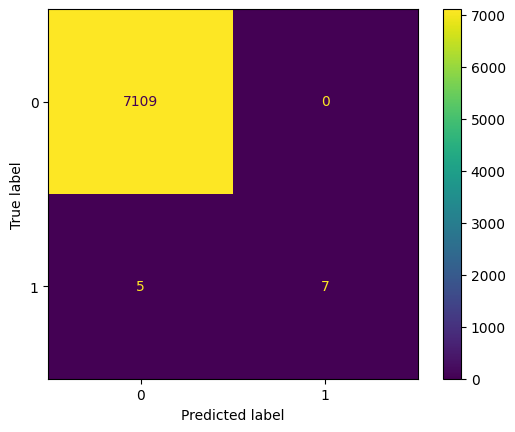

Threshold: 0.900000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7109
           1       1.00      0.08      0.15        12

    accuracy                           1.00      7121
   macro avg       1.00      0.54      0.58      7121
weighted avg       1.00      1.00      1.00      7121



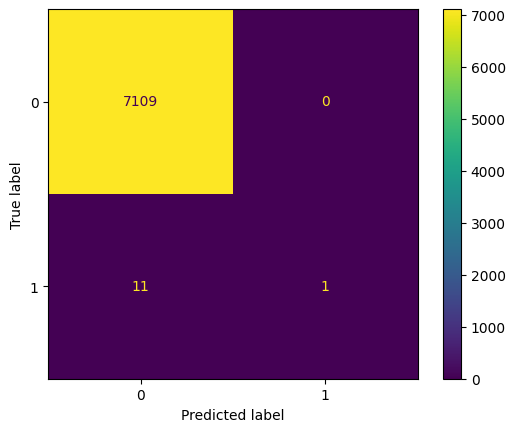

In [25]:
model = execute_ml(RandomForestClassifier(bootstrap = True,
                                  criterion='entropy',
                                  max_features = 'sqrt',
                                  random_state=12),
                   X_train, y_train, X_test, y_test)

drawROC(model, X_test, y_test)

for i in np.arange(0.1,1,0.2):
    execute_using_threshold(
        RandomForestClassifier(bootstrap = True,
                               criterion='entropy',
                               max_features = 'sqrt',
                               random_state=12),
        X_train, y_train,
        i)